# Tractably compute Maximum a Posteriori

Consider the case where we have $N$ binary variables $\mathbf{X}$ distributed according to uknown probability distribution $P(\mathbf{X})$ and we have a dataset $\mathcal{D}$ where a datapoint $d^{(i)} \in \mathcal{D}$ is distributed according to $P(\mathbf{X})$.

For example, $d^{(i)}$ could be a binary vector from a multi-label classification task, representing whether an object is present on an image or not.

We want to model the distribution $P(\mathbf{X})$ from the observations $\mathcal{D}$ and we want to know which is the most probable assignment. In the image example, which is the combination of objects that is most-likely to appear in the image.

To do so, we have to execute a MAP query on the distribution $P(\mathbf{X})$, which allows us to retrieve its most probable state.

We can do this by modeling $P(\mathbf{X})$ using a smooth, decomposable and deterministic circuit. Let's first build such a circuit that fully-factorizes the $N$ variables in `cirkit`.

In [27]:
import sys
sys.path.insert(0, "../")

from cirkit.templates.pgms import deterministic_fully_factorized

num_variables = 10

s_circuit = deterministic_fully_factorized(num_variables)

In [33]:
import torch
from cirkit.pipeline import PipelineContext

ctx = PipelineContext(backend="torch", semiring="sum-product", fold=True, optimize=True)
circuit = ctx.compile(s_circuit)

circuit(torch.randint(2, size=(3, num_variables)))

tensor([[[1.5298e-04]],

        [[1.5142e-06]],

        [[8.5994e-05]]], grad_fn=<TransposeBackward0>)

Let's create some synthetic data to simulate our use case. We set $P(\mathbf{X}) \sim Cat(N, \mathbf{p})$ with 

$$x_i \sim \begin{cases}
3 \\
\mathcal{U}(0, 1) & \text{otherwise} \\
\end{cases}$$

and $\mathbf{p} = softmax([x_0, \cdots, x_N])$.

The resulting distribution places most of the probability mass to the fourth variable (counting from 0).

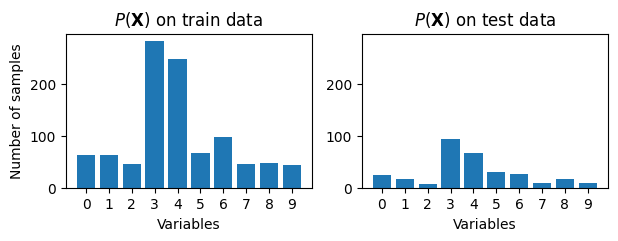

In [34]:
import torch.distributions as D
import torch.nn.functional as F
import matplotlib.pyplot as plt

data_p = torch.rand(num_variables)
data_p[3] = 2
data_p[4] = 1.8
data_p = data_p.softmax(dim=-1)

train_P_X = D.OneHotCategorical(probs=data_p).sample(sample_shape=torch.tensor([1000,]))
test_P_X = D.OneHotCategorical(probs=data_p).sample(sample_shape=torch.tensor([300,]))

fig, axs = plt.subplots(1, 2, figsize=(7, 2))

_, train_count = train_P_X.argmax(dim=-1).unique(return_counts=True)
_, test_count = test_P_X.argmax(dim=-1).unique(return_counts=True)

axs[0].bar([str(v) for v in range(num_variables)], train_count)
axs[0].set_xlabel("Variables")
axs[0].set_ylabel("Number of samples")
axs[0].set_title(r"$P(\mathbf{X})$ on train data")

axs[1].bar([str(v) for v in range(num_variables)], test_count)
axs[1].set_xlabel("Variables")
axs[1].set_ylim(*axs[0].get_ylim())
axs[1].set_title(r"$P(\mathbf{X})$ on test data")
plt.show()

Let's train the circuit on this dataset.

In [35]:
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

data_train = TensorDataset(train_P_X)
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)

data_test = TensorDataset(test_P_X)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

num_epochs = 200
running_loss = 0
optimizer = optim.Adam(circuit.parameters(), lr=0.1)

for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(train_dataloader):
        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss * len(batch)


    if (epoch_idx % 50) == 0:
        print(f"Loss: {running_loss / len(data_train)}")
    running_loss = 0

Loss: -6.156013841973618e-05
Loss: -0.2815084755420685
Loss: -0.281794935464859
Loss: -0.28188496828079224


We can compute the MAP state using brute-force -- i.e. we enumerate all the possible variable assignments and take the one with maximum likelihood.

In [36]:
from itertools import product

assignments = torch.tensor(list(product(*([[0, 1]] * num_variables))))
assignments_l = circuit(assignments)

# take the assignment with maximum likelihood
map_state = assignments[assignments_l.argmax()]

print("MAP state:", map_state)

MAP state: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


The circuit learned the right distribution: the most probable state is the fourth variable. Unfortunately, we have an exponential number of assignment in the number of variables, hence this approach is not sustainable. 

Since the circuit is smooth, decomposable and deterministic, however, we can perform this operation more efficiently in `cirkit`! Specifically, we can do it in linear time.

In [37]:
from cirkit.backend.torch.queries import MAPQuery

map_query = MAPQuery(circuit)
map_state = map_query()
print("MAP state:", map_state)

MAP state: tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


We can also provide evidences and compute the MAP state with respect to those evidences. For instance, suppose we know that the first two variables are true and we want to compute the assignments to the remaining variables that maximizes the likelihood. In this case, since we have most of the probability mass on the fourth index we expect the resulting state to include that variable.

In [41]:
e = torch.tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
is_e = torch.tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]).bool()
map_state = map_query(x=e, evidence_vars=is_e)
print("MAP state with evidence", e, ":", map_state)

MAP state with evidence tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]) : tensor([[1, 1, 0, 1, 0, 0, 0, 0, 0, 0]])
